![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importación librerías
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score,classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import tensorflow.python.keras.backend as K 
sess = K.get_session()
from keras.models import Sequential
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Embedding
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
from keras import layers
%matplotlib inline

In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [6]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## 1.0 Descriptivo

In [7]:
#iniciamos el descriptivo
descripcion=dataTraining.describe(include="all")
print(descripcion)
print(dataTraining.columns)

               year                title  \
count   7895.000000                 7895   
unique          NaN                 7729   
top             NaN  Alice in Wonderland   
freq            NaN                    3   
mean    1989.726409                  NaN   
std       22.660717                  NaN   
min     1894.000000                  NaN   
25%     1980.000000                  NaN   
50%     1997.000000                  NaN   
75%     2007.000000                  NaN   
max     2015.000000                  NaN   

                                                     plot     genres  \
count                                                7895       7895   
unique                                               7894       1336   
top     an evil genius in a flying fortress is trying ...  ['Drama']   
freq                                                    2        429   
mean                                                  NaN        NaN   
std                                    

In [8]:
# validamos nuevamente la cantidad de filas y columnas
dataTraining.shape

(7895, 5)

In [9]:
# validando valores nulos
dataTraining.isna().any()

year      False
title     False
plot      False
genres    False
rating    False
dtype: bool

In [10]:
# tipos de datos
columnas_texto=[]
lista_columnas_df=dataTraining.columns
print("numero de columnas=",len(lista_columnas_df))
for i in range(len(lista_columnas_df)):
    print("columna",i,": ",dataTraining.iloc[1,i],"tipo:",type(dataTraining.iloc[1,i]))

numero de columnas= 5
columna 0 :  2008 tipo: <class 'numpy.int64'>
columna 1 :  How to Be a Serial Killer tipo: <class 'str'>
columna 2 :  a serial killer decides to teach the secrets of his satisfying career to a video store clerk . tipo: <class 'str'>
columna 3 :  ['Comedy', 'Crime', 'Horror'] tipo: <class 'str'>
columna 4 :  5.6 tipo: <class 'numpy.float64'>


In [11]:
# entendiendo la clasificacion year
dataTraining.year.describe()

count    7895.000000
mean     1989.726409
std        22.660717
min      1894.000000
25%      1980.000000
50%      1997.000000
75%      2007.000000
max      2015.000000
Name: year, dtype: float64

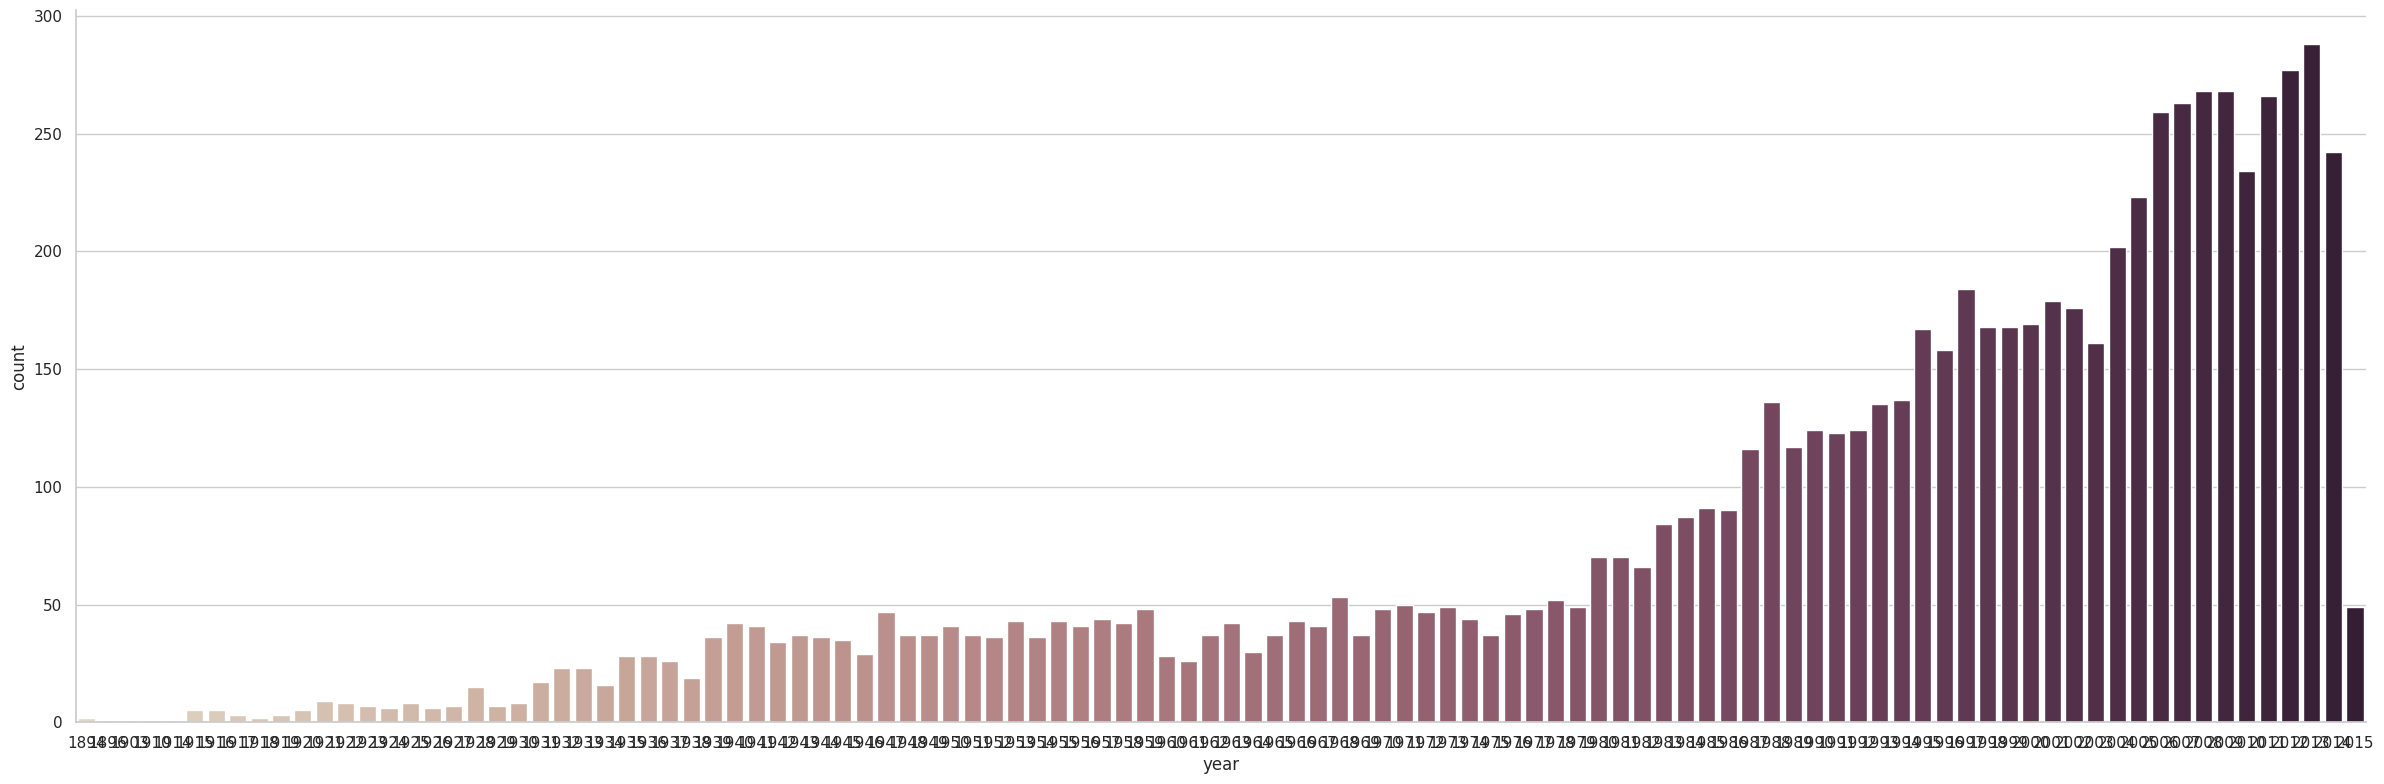

In [12]:
# Entendemos por el campo year
sns.set(style="whitegrid")
sns.catplot(x="year", kind="count", palette="ch:.25", data=dataTraining, height = 8, aspect = 3)

In [13]:
# entendiendo la clasificacion genero
dataTraining.genres.describe()

count          7895
unique         1336
top       ['Drama']
freq            429
Name: genres, dtype: object

In [14]:
# entendiendo la clasificacion rating
dataTraining.rating.describe()

count    7895.000000
mean        6.402812
std         1.078260
min         1.200000
25%         5.800000
50%         6.500000
75%         7.200000
max         9.300000
Name: rating, dtype: float64

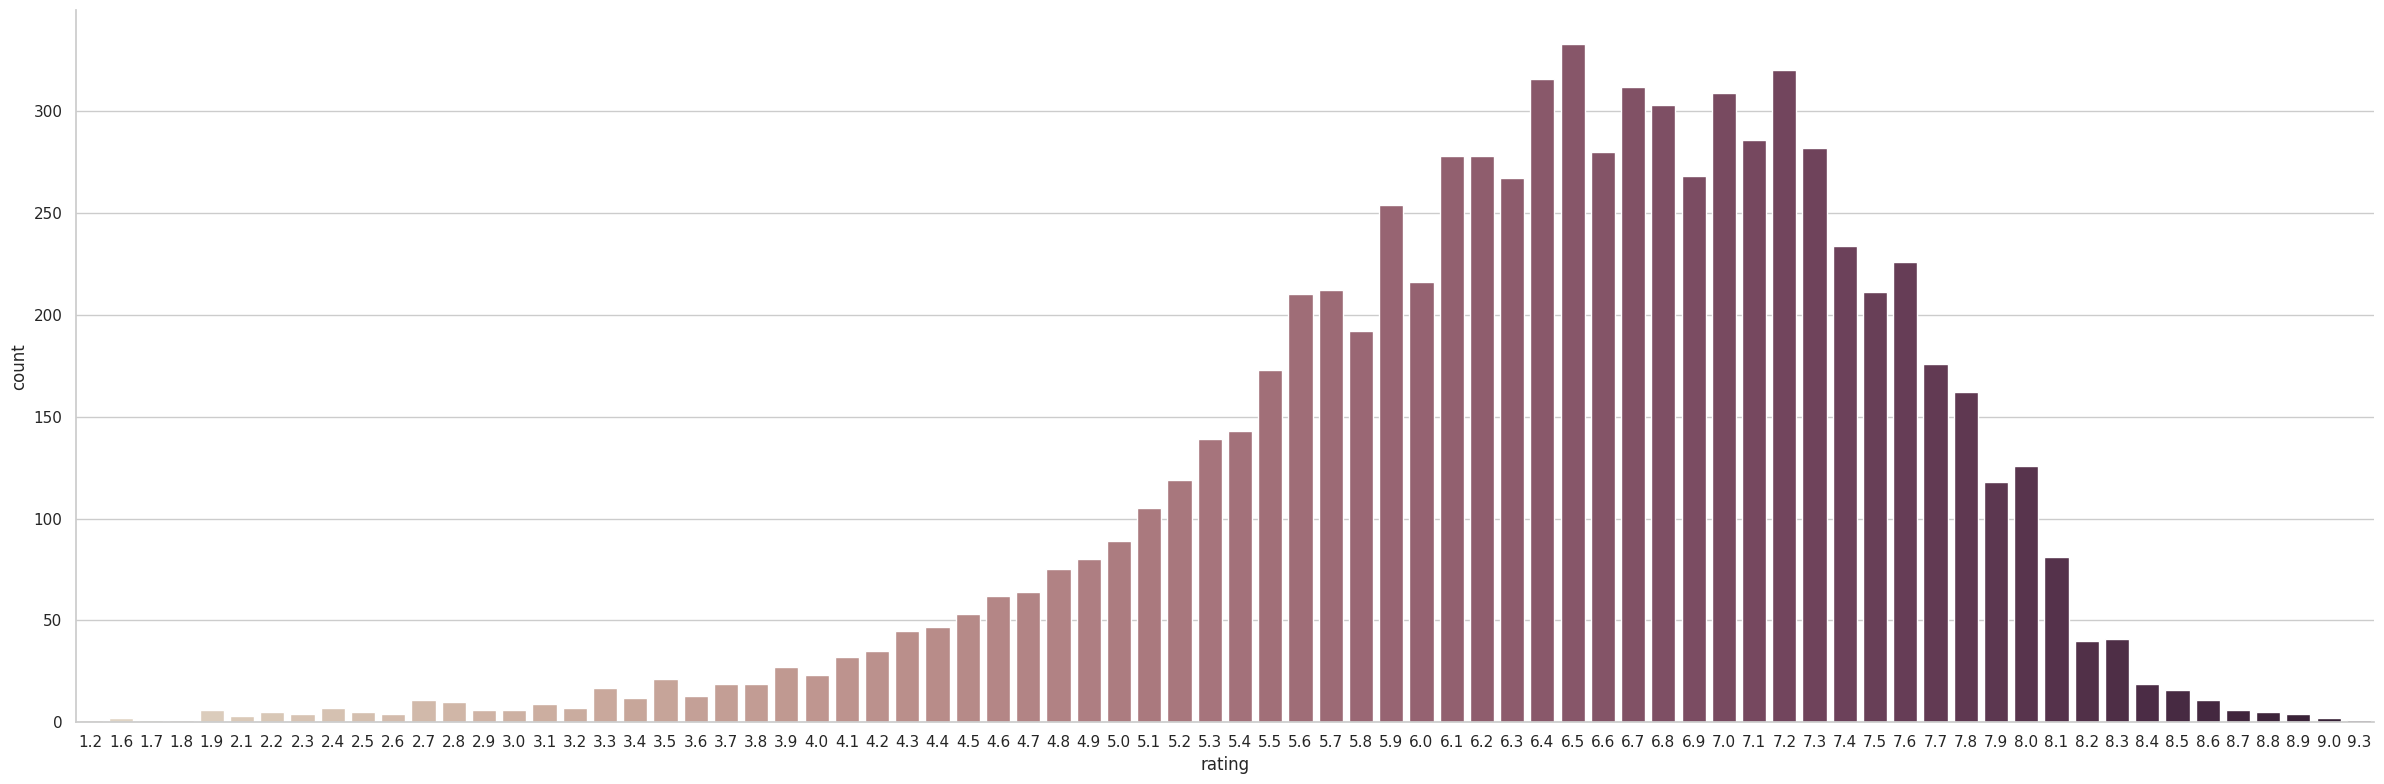

In [15]:
# Entendemos por el campo rating
sns.set(style="whitegrid")
sns.catplot(x="rating", kind="count", palette="ch:.25", data=dataTraining, height = 8, aspect = 3)

## 2.0 Modelo

###2.1 Count Vectorizer

In [16]:
# Definición de variables predictoras (X)
vect = CountVectorizer()
Xdtm = vect.fit_transform(dataTraining['plot'])
Xdtm.shape

(7895, 38672)

In [17]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
ygenres = le.fit_transform(dataTraining['genres'])

In [18]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdtm, ygenres, test_size=0.33, random_state=42)

In [19]:
# Definición y entrenamiento
Cvclf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=800, max_depth=10, random_state=42))
Cvclf.fit(Xtrain, ytrain)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=800,
                                                     n_jobs=-1,
                                                     random_state=42))

In [20]:
# Predicción del modelo de clasificación
yPredCv= Cvclf.predict_proba(Xtest)

In [21]:
# Impresión del desempeño del modelo
roc_auc_score(ytest, yPredCv, average='macro')

0.8241351928574887

In [22]:
# transformación variables predictoras X del conjunto de test
XtestdtmCv = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']


In [23]:
# Predicción del conjunto de test
ypredtestgenresCv = Cvclf.predict_proba(XtestdtmCv)

In [24]:
ypredtestgenresCv

array([[0.14435617, 0.11457215, 0.02494683, ..., 0.22966276, 0.03472732,
        0.0219217 ],
       [0.15541211, 0.11205394, 0.02504526, ..., 0.23024411, 0.03670971,
        0.02204567],
       [0.15684437, 0.11664907, 0.027155  , ..., 0.34447172, 0.04889846,
        0.02295368],
       ...,
       [0.14607157, 0.11429514, 0.02646912, ..., 0.23822533, 0.03471748,
        0.0247161 ],
       [0.18733672, 0.23442649, 0.02732827, ..., 0.24020819, 0.03960128,
        0.02502904],
       [0.16483457, 0.11224111, 0.02560728, ..., 0.28474681, 0.03483387,
        0.02193073]])

In [25]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(ypredtestgenresCv, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.144356,0.114572,0.024947,0.039487,0.384947,0.156192,0.045723,0.503891,0.071668,0.087622,...,0.027559,0.083167,0.000221,0.264584,0.074728,0.008376,0.024574,0.229663,0.034727,0.021922
4,0.155412,0.112054,0.025045,0.042255,0.369656,0.184586,0.058971,0.502116,0.073272,0.076225,...,0.027010,0.080755,0.000550,0.192216,0.073567,0.010024,0.023871,0.230244,0.036710,0.022046
5,0.156844,0.116649,0.027155,0.058096,0.324924,0.313387,0.036120,0.585934,0.079569,0.082876,...,0.032424,0.157812,0.000225,0.290255,0.085200,0.006964,0.026715,0.344472,0.048898,0.022954
6,0.167501,0.120664,0.025559,0.044168,0.364175,0.168945,0.040068,0.545248,0.073570,0.077129,...,0.030562,0.096451,0.000137,0.253121,0.092973,0.007208,0.026892,0.288965,0.045674,0.021878
7,0.171315,0.127452,0.025325,0.040678,0.359205,0.198558,0.039153,0.479972,0.077650,0.091890,...,0.028787,0.115536,0.001368,0.222947,0.157575,0.008357,0.023823,0.255420,0.034687,0.023065


### 2.2 TdiFVectorizer

In [26]:
# Celda 4
TfiVec = TfidfVectorizer()

In [27]:
XtfiVec = TfiVec.fit_transform(dataTraining['plot'])
XtfiVec.shape

(7895, 38672)

In [28]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
Xtraintf, Xtesttf, ytraintf, ytesttf = train_test_split(XtfiVec, ygenres, test_size=0.33, random_state=42)

In [29]:
# Creamos el objeto de clasificacion
tfclf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=800, max_depth=10, random_state=42))

In [30]:
#Entrenamos el modelo
tfclf.fit(Xtraintf, ytraintf)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=800,
                                                     n_jobs=-1,
                                                     random_state=42))

In [31]:
# Predicción del modelo de clasificación
yPredtf= tfclf.predict(Xtesttf)

In [32]:
# Impresión del desempeño del modelo
roc_auc_score(ytesttf, yPredtf, average='macro')

0.5074285155591061

In [33]:
# transformación variables predictoras X del conjunto de test
Xtestdtmtf = TfiVec.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [34]:
# Predicción del conjunto de test
ypredtestgenrestf = Cvclf.predict_proba(Xtestdtmtf)

In [35]:
# Guardar predicciones en formato exigido en la competencia de kaggle
restf = pd.DataFrame(ypredtestgenrestf , index=dataTesting.index, columns=cols)
restf.to_csv('pred_genres_text_tf.csv', index_label='ID')
restf.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.144198,0.11004,0.024854,0.039993,0.375697,0.155804,0.066697,0.477817,0.07162,0.075665,...,0.02701,0.080755,0.000711,0.193063,0.073567,0.009438,0.023858,0.2272,0.034834,0.021931
4,0.144198,0.11004,0.024854,0.039993,0.375697,0.155804,0.066697,0.477817,0.07162,0.075665,...,0.02701,0.080755,0.000711,0.193063,0.073567,0.009438,0.023858,0.2272,0.034834,0.021931
5,0.144198,0.11004,0.024854,0.039993,0.375697,0.155804,0.066697,0.477817,0.07162,0.075665,...,0.02701,0.080755,0.000711,0.193063,0.073567,0.009438,0.023858,0.2272,0.034834,0.021931
6,0.144198,0.11004,0.024854,0.039993,0.375697,0.155804,0.066697,0.477817,0.07162,0.075665,...,0.02701,0.080755,0.000711,0.193063,0.073567,0.009438,0.023858,0.2272,0.034834,0.021931
7,0.144198,0.11004,0.024854,0.039993,0.375697,0.155804,0.066697,0.477817,0.07162,0.075665,...,0.02701,0.080755,0.000711,0.193063,0.073567,0.009438,0.023858,0.2272,0.034834,0.021931


### 2.3 Redes Neuronales

In [36]:
# Definición de variables predictoras (X)
vectRN = CountVectorizer()
XRN = vect.fit_transform(dataTraining['plot'])
XRN.reshape

<bound method spmatrix.reshape of <7895x38672 sparse matrix of type '<class 'numpy.int64'>'
	with 634551 stored elements in Compressed Sparse Row format>>

In [37]:
# Definición de variable de interés (y)
yRN = le.fit_transform(dataTraining['genres'])

In [38]:
XtrainRN, XtestRN, ytrainRN, ytestRN = train_test_split(XRN, yRN, test_size=0.33, random_state=42)

In [39]:
model = Sequential()

#Defining layers of the model
#model.add(Flatten(input_shape=(64,)))
model.add(Dense(2056, activation='relu', input_shape = (38672,)))
#model.add(LSTM(2056, activation='relu', input_shape = (38672,)))
model.add(Dropout(0.5))
#model.add(Dense(24, activation='softmax')) 
model.add(Dense(24, activation='sigmoid')) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2056)              79511688  
                                                                 
 dropout (Dropout)           (None, 2056)              0         
                                                                 
 dense_1 (Dense)             (None, 24)                49368     
                                                                 
Total params: 79,561,056
Trainable params: 79,561,056
Non-trainable params: 0
_________________________________________________________________


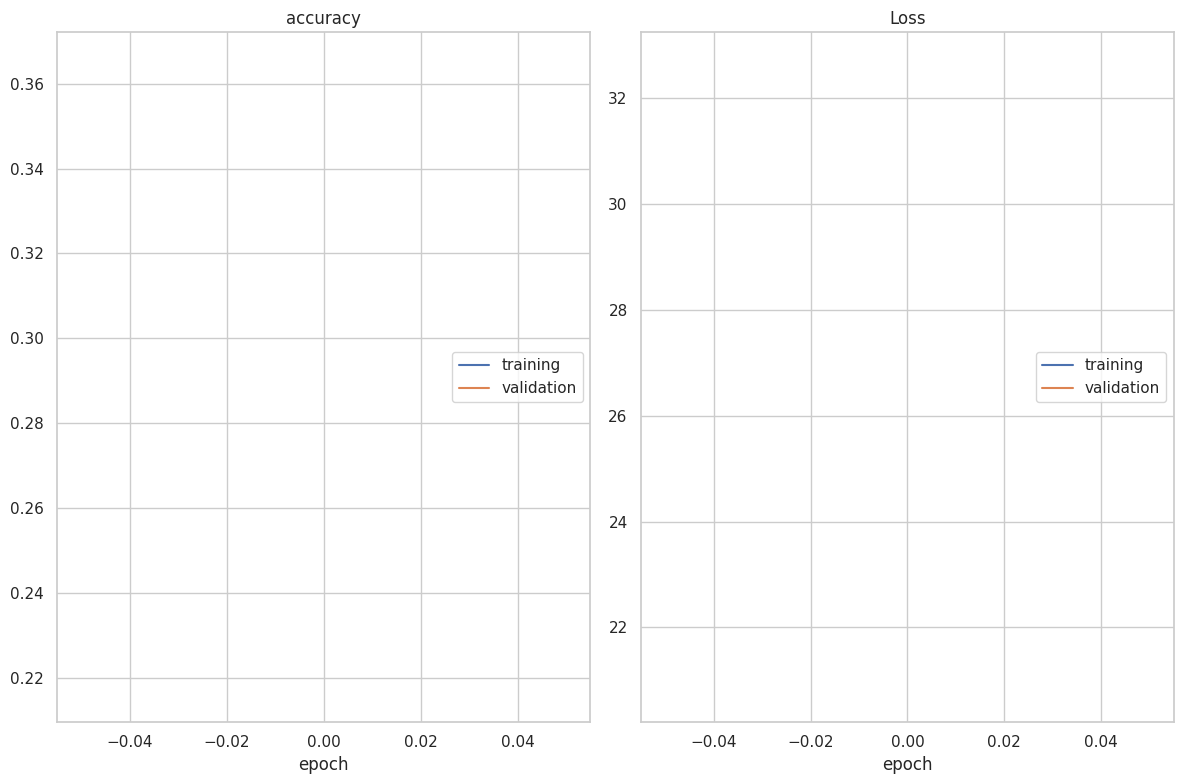

accuracy
	training         	 (min:    0.217, max:    0.217, cur:    0.217)
	validation       	 (min:    0.365, max:    0.365, cur:    0.365)
Loss
	training         	 (min:   20.804, max:   20.804, cur:   20.804)
	validation       	 (min:   32.640, max:   32.640, cur:   32.640)
42/42 [==============================] - 111s 3s/step - loss: 20.8036 - accuracy: 0.2169 - val_loss: 32.6401 - val_accuracy: 0.3647
Epoch 2/100
 3/42 [=>............................] - ETA: 1:24 - loss: 42.1542 - accuracy: 0.2135

KeyboardInterrupt: ignored

In [40]:
# fitting the Neural Network on the training data
hist = model.fit(XtrainRN.toarray(),ytrainRN, validation_data=(XtrainRN.toarray(),ytrainRN), 
          batch_size=128, epochs=100, verbose=1,
          callbacks=[PlotLossesKeras()])